# **Transaction Anomaly Detection**

## **Project Overview**
This project focuses on detecting anomalies in financial transactions using **Isolation Forest**, 
a machine learning algorithm for anomaly detection. The dataset contains details of transactions, 
including transaction amount, frequency, time of day, and user demographics.

### **Objective**
- Identify suspicious transactions that deviate significantly from normal behavior.
- Use **data visualization** and **machine learning** to classify anomalies.
- Implement an interactive system where users can input transaction details to check for anomalies.

---

In [1]:
import pandas as pd
import plotly.express as px
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE

## 1. Data Exploration

First, we load the dataset and explore its structure. This helps us understand the features 
and check for missing values.

In [2]:
data = pd.read_csv("data/transaction_anomalies_dataset.csv")
data.head()

,Transaction_ID,Transaction_Amount,Transaction_Volume,Average_Transaction_Amount,Frequency_of_Transactions,Time_Since_Last_Transaction,Day_of_Week,Time_of_Day,Age,Gender,Income,Account_Type
0,TX0,1024.835708,3,997.234714,12,29,Friday,06:00,36,Male,1436074,Savings
1,TX1,1013.952065,4,1020.210306,7,22,Friday,01:00,41,Female,627069,Savings
2,TX2,970.956093,1,989.496604,5,12,Tuesday,21:00,61,Male,786232,Savings
3,TX3,1040.822254,2,969.522480,16,28,Sunday,14:00,61,Male,619030,Savings
4,TX4,998.777241,1,1007.111026,7,7,Friday,08:00,56,Female,649457,Savings


In [3]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 12 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Transaction_ID               1000 non-null   object 
 1   Transaction_Amount           1000 non-null   float64
 2   Transaction_Volume           1000 non-null   int64  
 3   Average_Transaction_Amount   1000 non-null   float64
 4   Frequency_of_Transactions    1000 non-null   int64  
 5   Time_Since_Last_Transaction  1000 non-null   int64  
 6   Day_of_Week                  1000 non-null   object 
 7   Time_of_Day                  1000 non-null   object 
 8   Age                          1000 non-null   int64  
 9   Gender                       1000 non-null   object 
 10  Income                       1000 non-null   int64  
 11  Account_Type                 1000 non-null   object 
dtypes: float64(2), int64(5), object(5)
memory usage: 93.9+ KB
None


In [4]:
print(data.describe())

       Transaction_Amount  Transaction_Volume  Average_Transaction_Amount  \
count         1000.000000         1000.000000                 1000.000000   
mean          1038.122511            2.498000                 1000.682506   
std            283.580055            1.115006                   20.632334   
min            849.024392            1.000000                  939.081423   
25%            966.028796            1.000000                  986.800556   
50%           1002.118678            3.000000                 1000.501902   
75%           1033.143657            3.000000                 1015.155595   
max           3227.459108            4.000000                 1073.154036   

       Frequency_of_Transactions  Time_Since_Last_Transaction          Age  \
count                1000.000000                  1000.000000  1000.000000   
mean                   12.078000                    15.341000    40.641000   
std                     4.245225                     8.361258    13.8199

## 2. Data Visualization

We analyze the distribution of transaction amounts and their relationships with other features.

In [5]:
# Transaction Amount by Account Type
fig_box_amount = px.box(data,
                        x='Account_Type',
                        y='Transaction_Amount',
                        title='Transaction Amount by Account Type')
fig_box_amount.show()

In [6]:
# Average Transaction Amount vs. Age
fig_scatter_avg_amount_age = px.scatter(data, x='Age',
                                        y='Average_Transaction_Amount',
                                        color='Account_Type',
                                        title='Average Transaction Amount vs. Age',
                                        trendline='ols')
fig_scatter_avg_amount_age.show()

In [7]:
# Count of Transactions by Day of the Week
fig_day_of_week = px.bar(data, x='Day_of_Week',
                         title='Count of Transactions by Day of the Week')
fig_day_of_week.show()

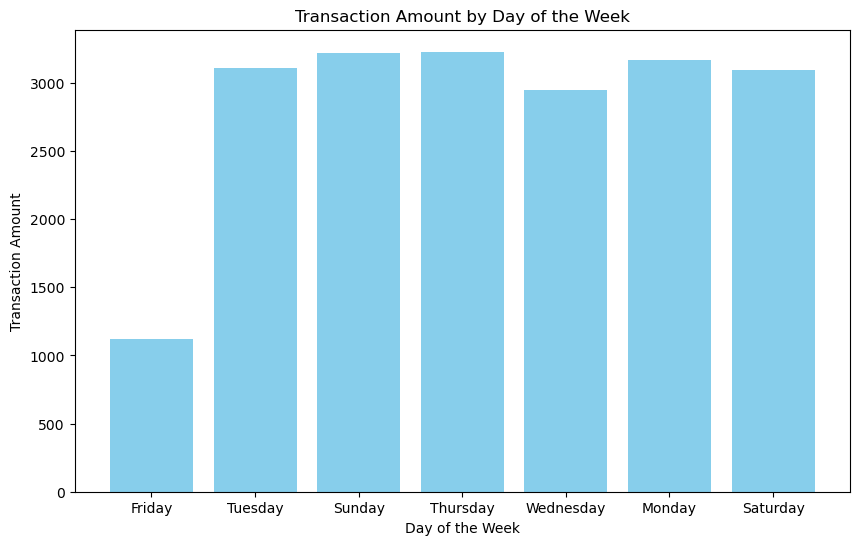

In [8]:
plt.figure(figsize=(10, 6))
plt.bar(data['Day_of_Week'], height=data['Transaction_Amount'], color='skyblue')
plt.title('Transaction Amount by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Transaction Amount')
plt.show()

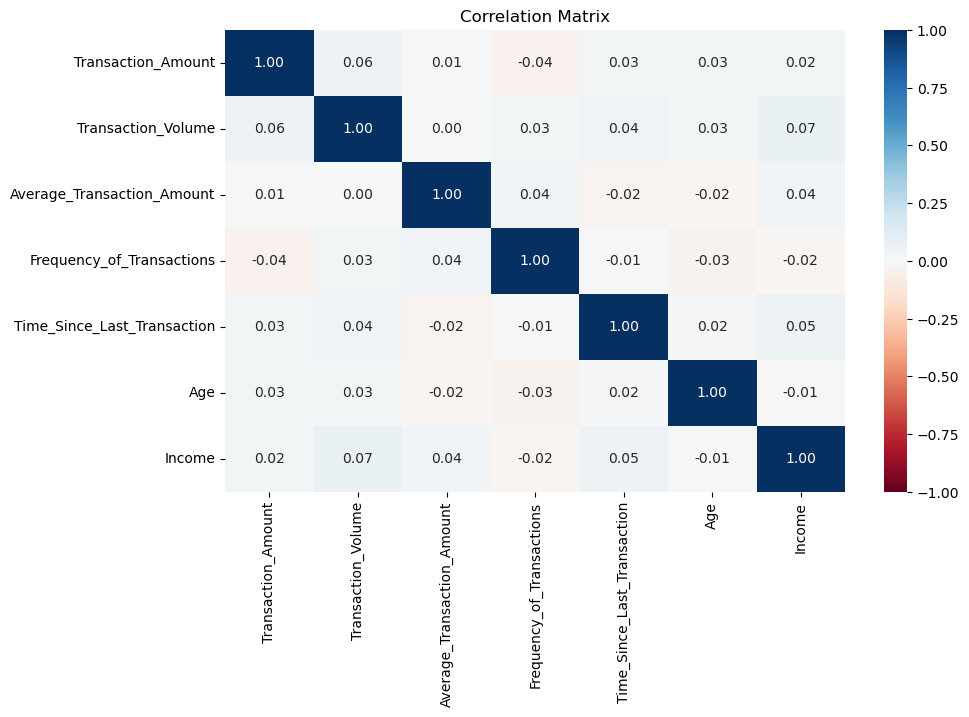

In [9]:
correlation_matrix = data.select_dtypes(include='number').corr()

# PLot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='RdBu', fmt='.2f', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

## 3. Anomaly Detection

We define anomalies as transactions that exceed **two standard deviations** from the mean transaction amount.

In [10]:
# Calculate mean and standard deviation of Transaction Amount
mean_amount = data['Transaction_Amount'].mean()
std_amount = data['Transaction_Amount'].std()

# Define the anomaly threshold (2 standard deviations from the mean)
anomaly_threshold = mean_amount + 2 * std_amount

# Flag anomalies
data['Is_Anomaly'] = data['Transaction_Amount'] > anomaly_threshold

# Scatter plot of Transaction Amount with anomalies highlighted
fig_anomalies = px.scatter(data, x='Transaction_Amount', y='Average_Transaction_Amount',
                           color='Is_Anomaly', title='Anomalies in Transaction Amount')
fig_anomalies.update_traces(marker=dict(size=12), 
                            selector=dict(mode='markers', marker_size=1))
fig_anomalies.show()

In [11]:
# Calculate the number of anomalies
num_anomalies = data['Is_Anomaly'].sum()

# Calculate the total number of instances in the dataset
total_instances = data.shape[0]

# Calculate the ratio of anomalies
anomaly_ratio = num_anomalies / total_instances

print(f'Number of anomalies: {num_anomalies}')
print(f'% of anomalies in the data: {anomaly_ratio:.2%}')

Number of anomalies: 20
% of anomalies in the data: 2.00%


## 4. Model Training (Isolation Forest)

We use **Isolation Forest** to detect anomalies. Before training, we balance the dataset using **SMOTE**.

In [12]:
relevant_features = ['Transaction_Amount',
                     'Average_Transaction_Amount',
                     'Frequency_of_Transactions']

# Split data into features (X) and target variable (y)
X = data[relevant_features]
y = data['Is_Anomaly']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

smote = SMOTE(sampling_strategy=0.1, random_state=42)  # Increase anomalies to 10%
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Train the Isolation Forest model
model = IsolationForest(contamination=0.02, random_state=42)
model.fit(X_train_balanced)

IsolationForest(contamination=0.02, random_state=42)

## 5. Model Evaluation

We evaluate the **precision, recall, and accuracy** of our model using a confusion matrix and classification report.
"""

In [13]:
# Predict anomalies on the test set
y_pred = model.predict(X_test)

# Convert predictions to binary values (0: normal, 1: anomaly)
y_pred_binary = [1 if pred == -1 else 0 for pred in y_pred]

# Evaluate the model's performance
report = classification_report(y_test, y_pred_binary, target_names=['Normal', 'Anomaly'])
print(report)

# Print confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_binary)
print(conf_matrix)

              precision    recall  f1-score   support

      Normal       0.99      1.00      1.00       196
     Anomaly       1.00      0.75      0.86         4

    accuracy                           0.99       200
   macro avg       1.00      0.88      0.93       200
weighted avg       1.00      0.99      0.99       200

[[196   0]
 [  1   3]]


## 6. Interactive Anomaly Detection

Users can enter transaction details to check if their transaction is classified as an anomaly.

In [14]:
# Relevant features used during training
relevant_features = ['Transaction_Amount', 'Average_Transaction_Amount', 'Frequency_of_Transactions']

# Get user inputs for features
user_inputs = []
for feature in relevant_features:
    user_input = float(input(f"Enter the value for '{feature}': "))
    user_inputs.append(user_input)

# Create a DataFrame from user inputs
user_df = pd.DataFrame([user_inputs], columns=relevant_features)

# Predict anomalies using the model
user_anomaly_pred = model.predict(user_df)

# Convert the prediction to binary value (0: normal, 1: anomaly)
user_anomaly_pred_binary = 1 if user_anomaly_pred == -1 else 0

if user_anomaly_pred_binary == 1:
    print("Anomaly detected: This transaction is flagged as an anomaly.")
else:
    print("No anomaly detected: This transaction is normal.")

Anomaly detected: This transaction is flagged as an anomaly.
